# 2D Schrodinger Equation with Coulomb Potential

In [8]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS

In [9]:
# Define parameters of problem
center = (0,0)
centerX,centerY = center
Z = 1
epsilon = 1e-3

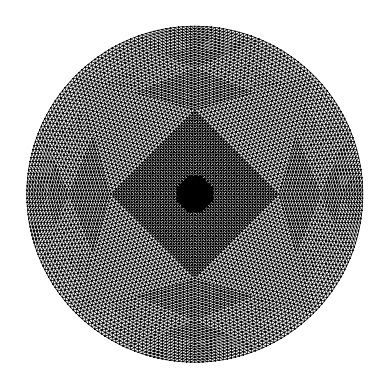

In [10]:
def create_refined_mesh(radius=10.0, initial_refs=6, refine_steps=5, refine_radius=1.0):
    """
    Creates a circular mesh with heavy refinement at the origin to handle
    the Coulomb singularity.
    """
    # 1. Initialize a standard circle
    mesh = fem.MeshTri.init_circle(nrefs=initial_refs)
    
    # Scale the mesh to the desired physical domain size
    # init_circle creates a unit circle, so we multiply nodes by radius
    mesh = mesh.scaled(radius)

    # 2. Iteratively refine elements near the origin
    for _ in range(refine_steps):
        # Calculate the centroid of every element
        # mesh.p are points, mesh.t are triangles (topology)
        x_centers = mesh.p[0, mesh.t].mean(axis=0)
        y_centers = mesh.p[1, mesh.t].mean(axis=0)
        
        # Calculate distance from origin
        dist = jnp.sqrt((x_centers-centerX)**2 + (y_centers-centerY)**2)
        
        # Identify elements within the refinement radius
        # We shrink the refinement radius slightly each pass to concentrate nodes at 0
        elements_to_refine = jnp.nonzero(dist < refine_radius)[0]
        
        if len(elements_to_refine) > 0:
            mesh = mesh.refined(elements_to_refine)
            refine_radius *= 0.7 # Focus in tighter on the next loop
            
    return mesh

# Generate the mesh
mesh = create_refined_mesh()

# Quick visual check (if you use matplotlib)
mesh.draw().show()

Functional = $\int |\nabla u|^2 - (Z/r)u^2 $

Hamiltonian of this functional: 

In [11]:
# Step 1: Define FEM System
element = fem.ElementTriP1()
intorder = 5
femsystem = FEMSystem(mesh,element,intorder)

# Step 2: Define Objective, in terms of u_interior
def v(x_vec):
    x,y = x_vec[0],x_vec[1]
    return - Z / jnp.sqrt((x-centerX)**2 + (y-centerY)**2 + epsilon)

def ke(u,grad_u,x):
    return jnp.sum(grad_u ** 2, axis=0) / 2

def pe(u,grad_u,x):
    return v(x) * u**2

def norm(u,grad_u,x):
    return u ** 2

def objective(u_interior):
    # Primary Objective 
    u_global = femsystem.apply_bc_and_norm(u_interior)
    ke_int = femsystem.integrate(ke,u_global)
    pe_int = femsystem.integrate(pe,u_global)
    obj =  ke_int + pe_int
    return obj

# Step 3: Run Minimization Loop
u_init_interior = femsystem.get_initial_ones_interior()
print("\nStarting Optimization...")
# Use JAX's BFGS optimizer
solver = LBFGS(fun=objective,tol=1e-10,verbose=True)
result = solver.run(u_init_interior)
result = result.params 
u_interior = result


Starting Optimization...
INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.06762826442718506 Objective Value:0.3389737010002136  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.02086097002029419 Objective Value:-0.0036415010690689087  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.017040586099028587 Objective Value:-0.0429665744304657  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.01627919264137745 Objective Value:-0.08856981247663498  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.020544027909636497 Objective Value:-0.10571643710136414  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.011511876247823238 Objective Value:-0.12031431496143341  Stepsize:1

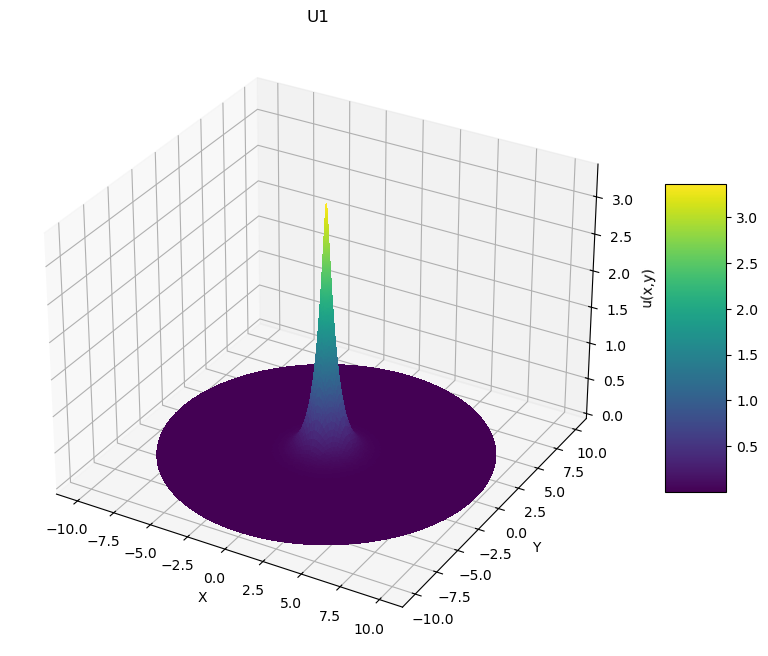

In [5]:
femsystem.plot_at_interior_2d_in3d(u_interior,plot_title="U1")

# Check Against Analytical Solution

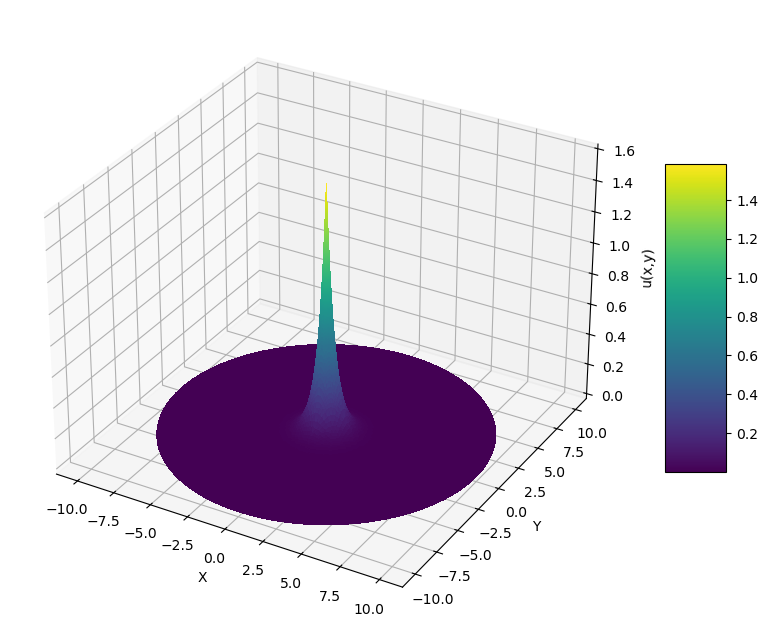

In [6]:
def analytical(x_vec):
    x,y = x_vec[0],x_vec[1]
    r = jnp.sqrt((x-centerX)**2+ (y-centerY)**2)
    return Z * jnp.sqrt(8 / jnp.pi)*jnp.exp(-2 * Z * r)

femsystem.plot_func_2d_in3d(lambda a,b: analytical([a,b]))

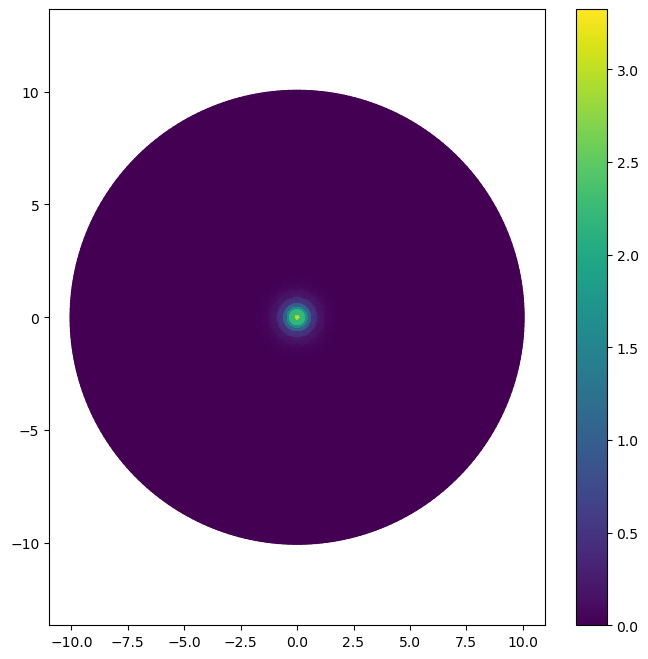

In [7]:
diffs = femsystem.compare_at_quads(analytical,femsystem._get_u_from_interior(u_interior))
femsystem.plot_at_quad_2d(diffs)